# Check Impact of ```repetitions``` on Regression Uncertainties

<hr/>

## Prerequisites

#### Imports

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

from ensemble_uncertainties.model_library import models
from ensemble_uncertainties.evaluators.evaluator_support import format_time_elapsed
from ensemble_uncertainties.evaluators.regression_evaluator import RegressionEvaluator
from ensemble_uncertainties.utils.ad_assessment import rmses_frac

#### Constants

In [2]:
RANDOM_SEED = 0
TRYOUT_REPETITIONS = [5, 10, 20, 100]
TASK = 'regression'
N_SPLITS = 2
PLOT_FOLDER = './different_reps_regression_plots/'

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(RANDOM_SEED)

#### Functions

In [4]:
def load_data_set(name, descriptor):
    """Loads X and y as dataframes from data folder."""
    folder = f'../../../data/featurized/{TASK}/{name}/'
    X_file = f'{folder}{name}_{descriptor}.csv'
    y_file = f'{folder}{name}_y.csv'
    X = pd.read_csv(X_file, sep=';').set_index('id')
    y = pd.read_csv(y_file, sep=';').set_index('id')
    return X, y


def get_measure_rmses(evaluator):
    """Extracts confidence curve values from an Evaluator."""
    resids = evaluator.test_ensemble_preds['resid']
    uncertainties = evaluator.test_ensemble_preds['sdep']
    oracle_rmses, measure_rmses = rmses_frac(resids, uncertainties)
    return measure_rmses


def plot_comparison(evaluators, title, ax1, ax2):
    """Plots confidence curves for several evaluators."""
    repetitionss = list()
    times = list()
    formatted_times = list()
    # Plot uncertainty performances
    ax1.grid(zorder=1000)
    for evaluator in evaluators:
        repetitions = evaluator.repetitions
        repetitionss.append(repetitions)
        times.append(
            evaluator.overall_run_time.total_seconds()
        )
        formatted_times.append(
            format_time_elapsed(evaluator.overall_run_time).replace('.', '\n')
        )
        rmses = get_measure_rmses(evaluator)
        x_space = np.linspace(0.0, 100.0, len(rmses))
        ax1.plot(x_space, rmses, zorder=100, 
            label=f'repetitions = {repetitions}')
    ax1.set_title(title)
    ax1.set_xlabel('Percentile')
    ax1.set_ylabel('$RMSE$')
    ax1.legend()
    # Plot times
    ax2.grid(zorder=1000)
    ax2.bar(formatted_times, times, zorder=100,
        color=[f'C{i}' for i in range(len(repetitionss))])
    ax2.set_title('')
    ax2.set_xlabel('')
    ax2.set_ylabel('Runtime [s]') 
    colors = dict(zip([f'repetitions = {n}' for n in repetitionss], [f'C{i}' for i in range(len(repetitionss))]))        
    labels = list(colors.keys())
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    ax2.legend(handles, labels)
    # Done at the end to avoid the "Formatter-warning"
    ax2.set_xticks(formatted_times)
    ax2.set_xticklabels(formatted_times, rotation=90)
    
    
def compare_repetitions(name, descriptor, model_name, ax1, ax2, tryout_repetitions=TRYOUT_REPETITIONS, n_splits=N_SPLITS, scale=True):
    """Evaluates the uncertainty estimation for one dataset, one model,
    and one descriptor, but for several repetitions, and plots the results.
    """
    X, y = load_data_set(name, descriptor)
    model = models['regression'][model_name]
    evaluators = list()
    for i, repetitions in enumerate(tryout_repetitions):
        print(f'Repetition [{i+1}/{len(tryout_repetitions)}]')
        evaluator = RegressionEvaluator(
            model=model,
            repetitions=repetitions,
            n_splits=n_splits,
            verbose=False,
            scale=scale
        )
        evaluator.perform(X, y)
        evaluators.append(evaluator)
    plot_comparison(evaluators, f'{name}, {descriptor},\n{model_name}, {n_splits} splits', ax1, ax2)
    
    
def evaluation_automatization(name, descriptor, methods, tryout_repetitions=TRYOUT_REPETITIONS,
                              n_splits=N_SPLITS, plots_folder=PLOT_FOLDER, scale=True):
    """Evaluates the uncertainty estimation for one dataset featurized by
    one descriptor, several models, several repetitions, and plots the results.
    """
    n_methods = len(methods)
    fig, pre_axes = plt.subplots(2, n_methods, figsize=(5*n_methods, 10))
    # Transpose axes
    axes = zip(*pre_axes)
    for method, ax in zip(methods, axes):
        print(f'\nAt {method}.')
        uax, tax = ax
        compare_repetitions(
            name,
            descriptor,
            method,
            uax,
            tax,
            tryout_repetitions=tryout_repetitions,
            n_splits=n_splits,
            scale=scale
        )
    if plots_folder:
        image_path = f'{plots_folder}{name}_{descriptor}_{"_".join(methods)}.png'
        plt.savefig(image_path, bbox_inches='tight', pad_inches=0.01)
    plt.show()    

<hr/>

## Evaluate

#### Test a small run:

  0%|          | 0/5 [00:00<?, ?it/s]


At svm_rbf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [07:08<00:00,  4.28s/it]


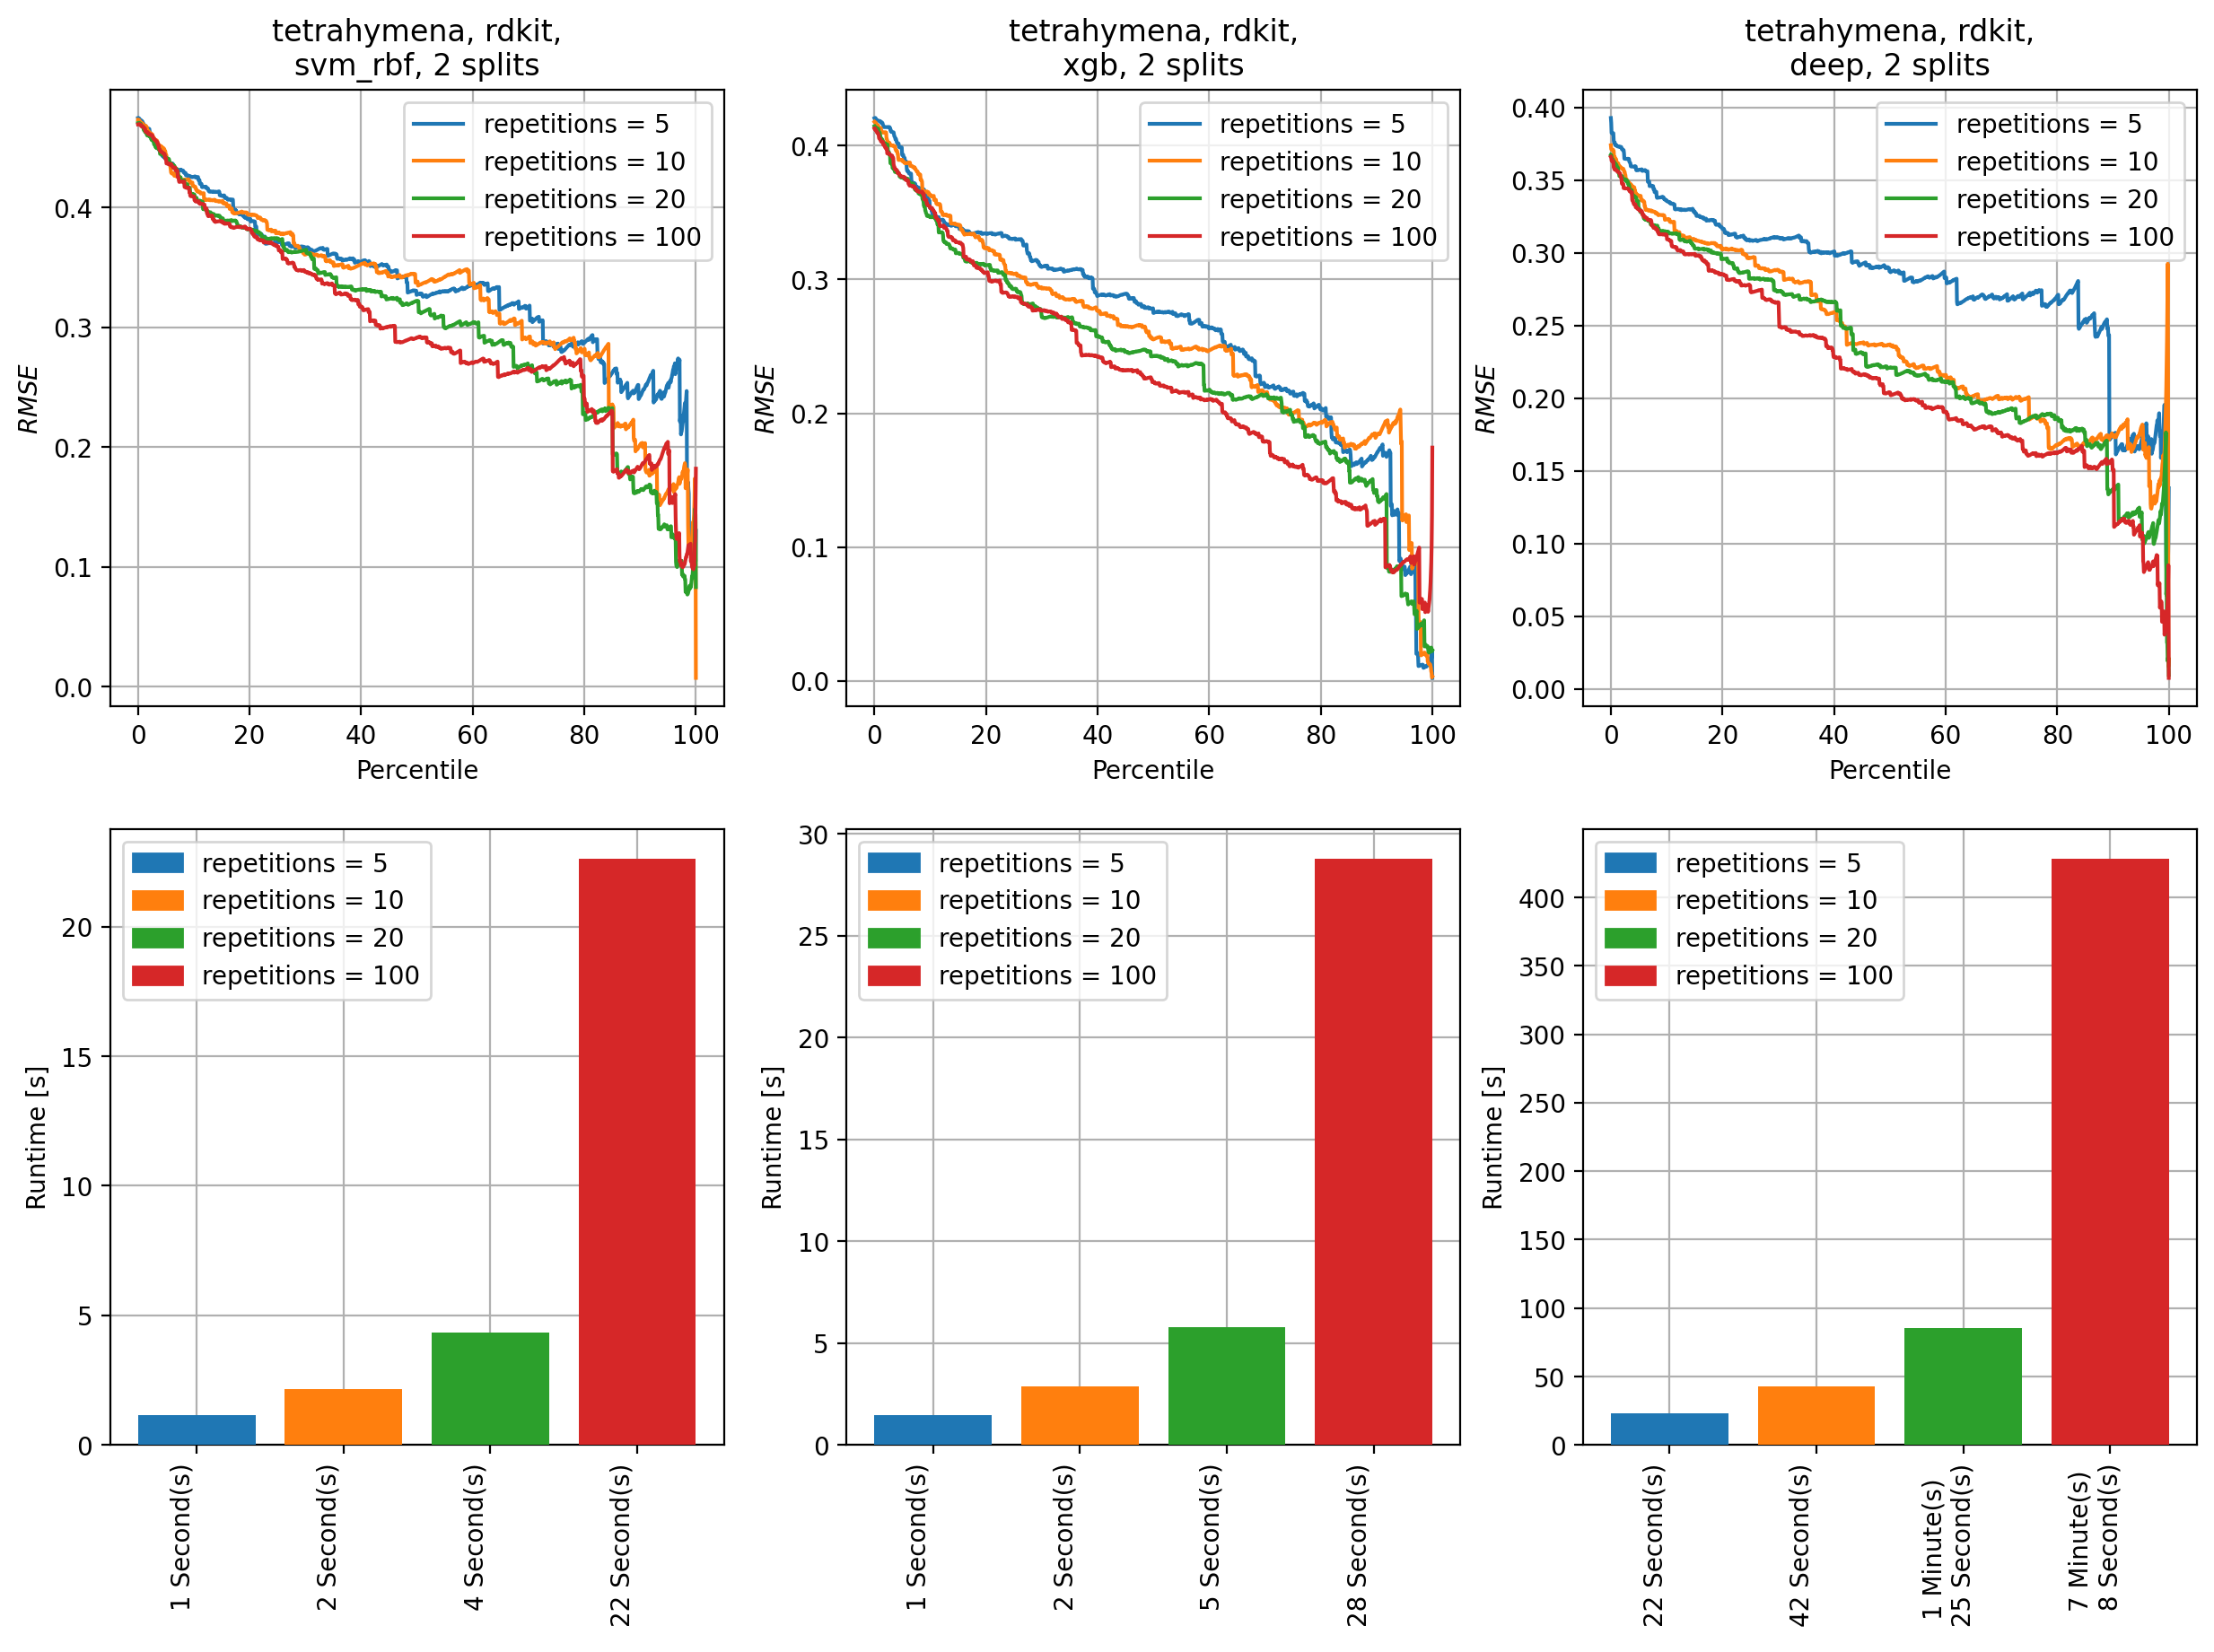

In [5]:
evaluation_automatization('tetrahymena', 'rdkit', ['svm_rbf', 'xgb', 'deep'])

### Tetrahymena, RDKit descriptors, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At svm_rbf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [07:09<00:00,  4.29s/it]


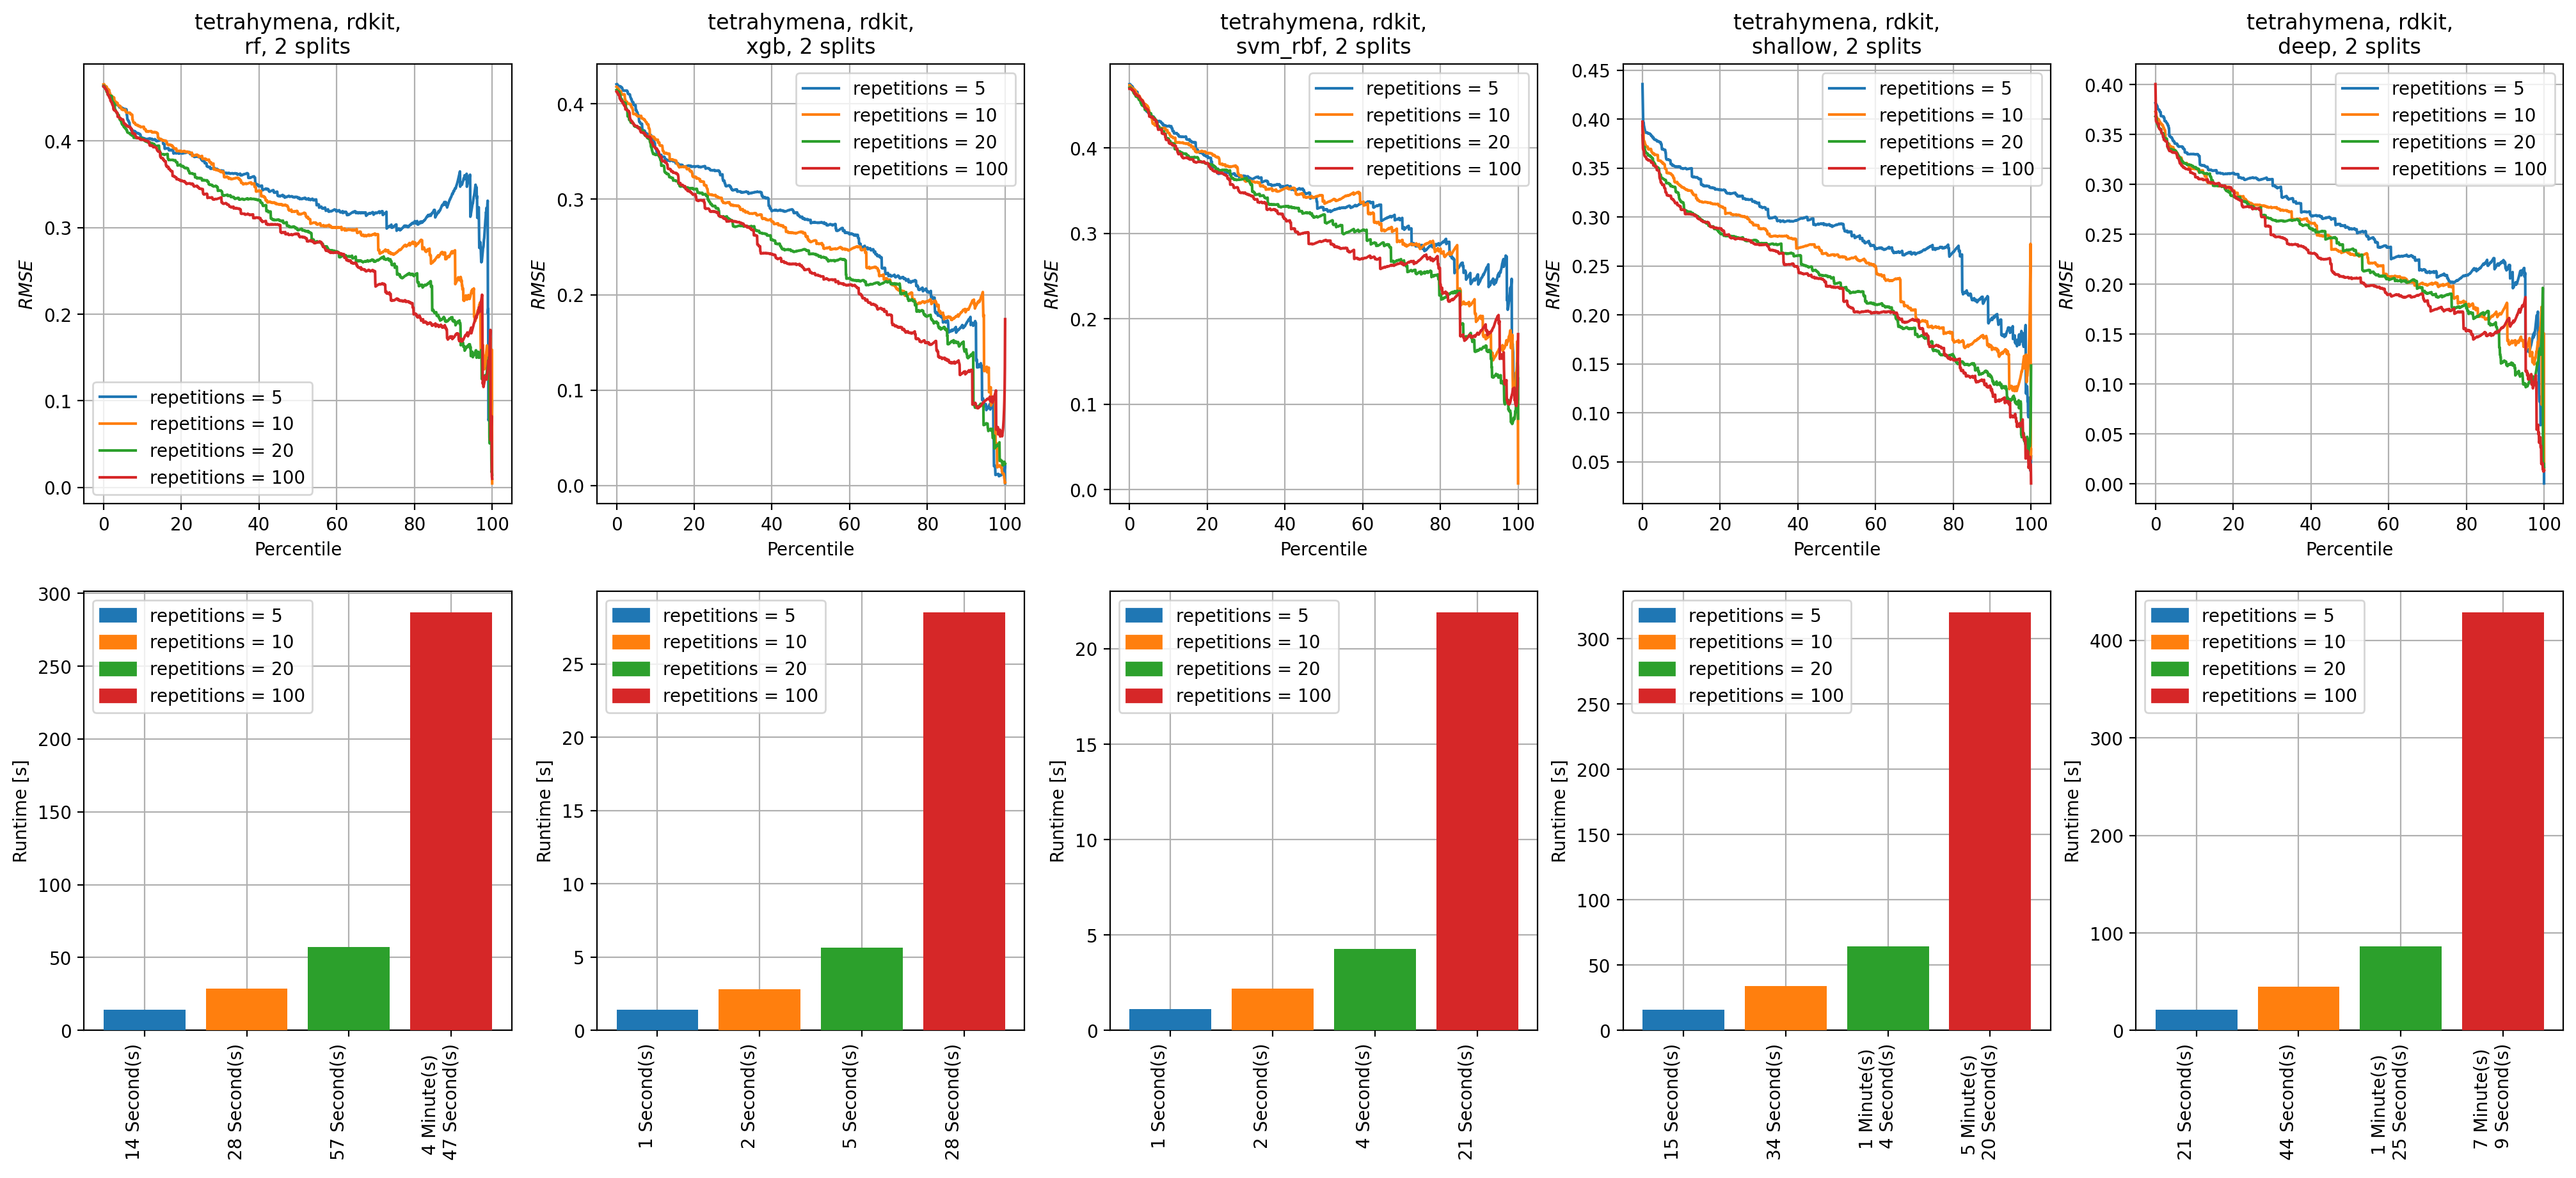

In [6]:
evaluation_automatization('tetrahymena', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])

### Tetrahymena, CDDD, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At svm_rbf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [07:23<00:00,  4.44s/it]


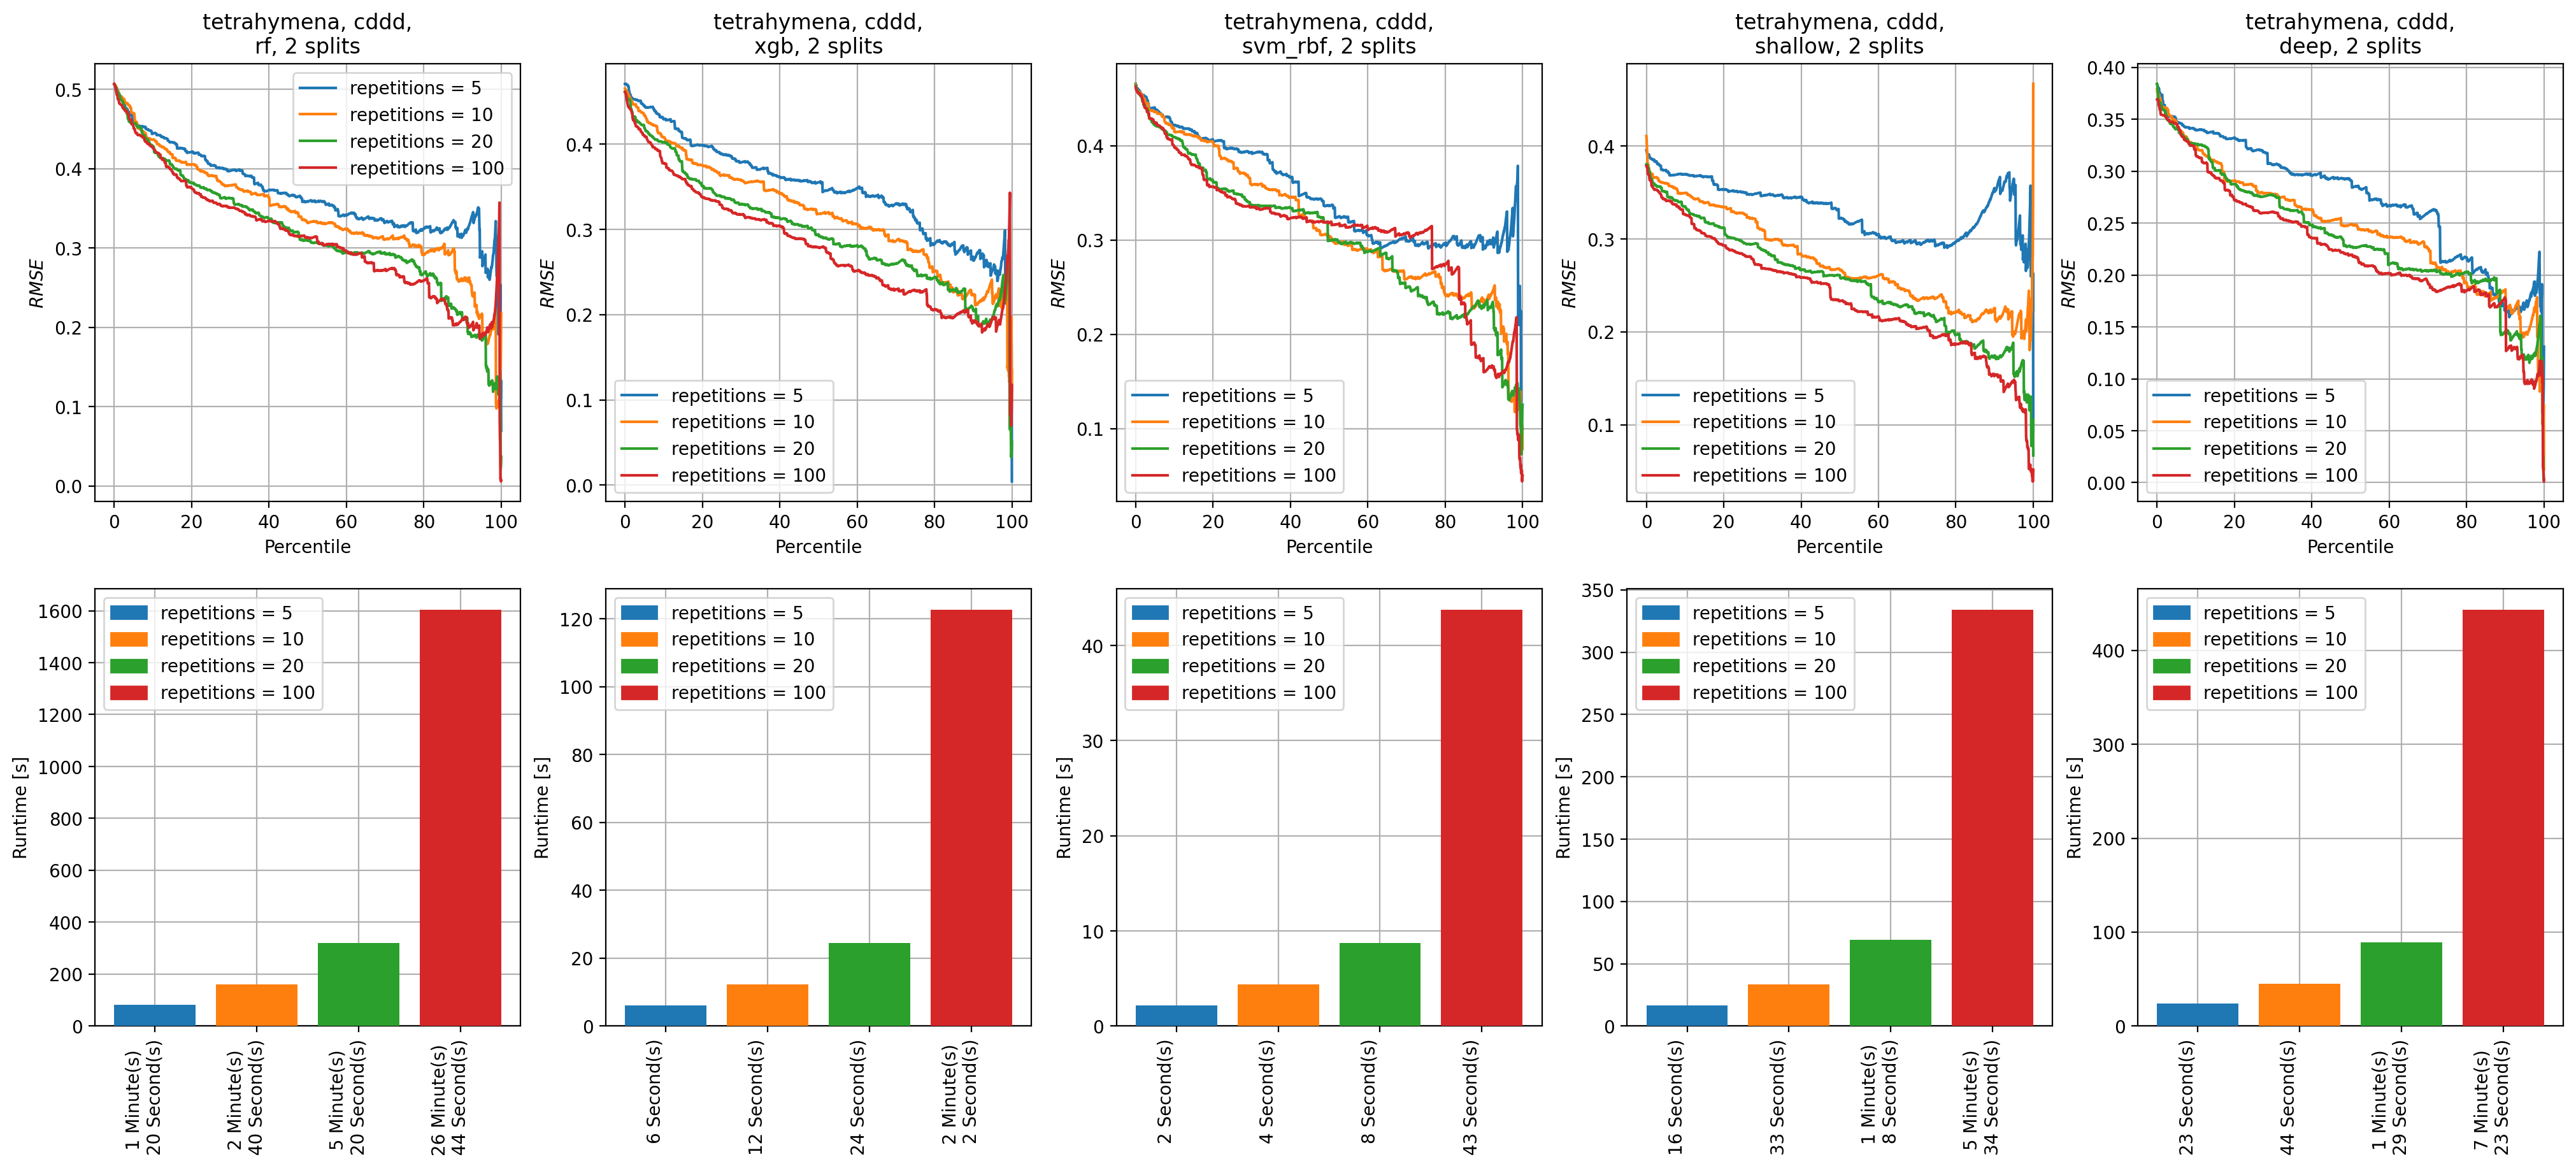

In [7]:
evaluation_automatization('tetrahymena', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])

### Tetrahymena, MACCS, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


 20%|██        | 1/5 [00:00<00:00,  5.42it/s]


At xgb.
Repetition [1/4]


 10%|█         | 1/10 [00:00<00:01,  5.42it/s]

Repetition [2/4]


  5%|▌         | 1/20 [00:00<00:03,  5.42it/s]

Repetition [3/4]


  1%|          | 1/100 [00:00<00:19,  5.18it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At svm_rbf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [07:10<00:00,  4.30s/it]


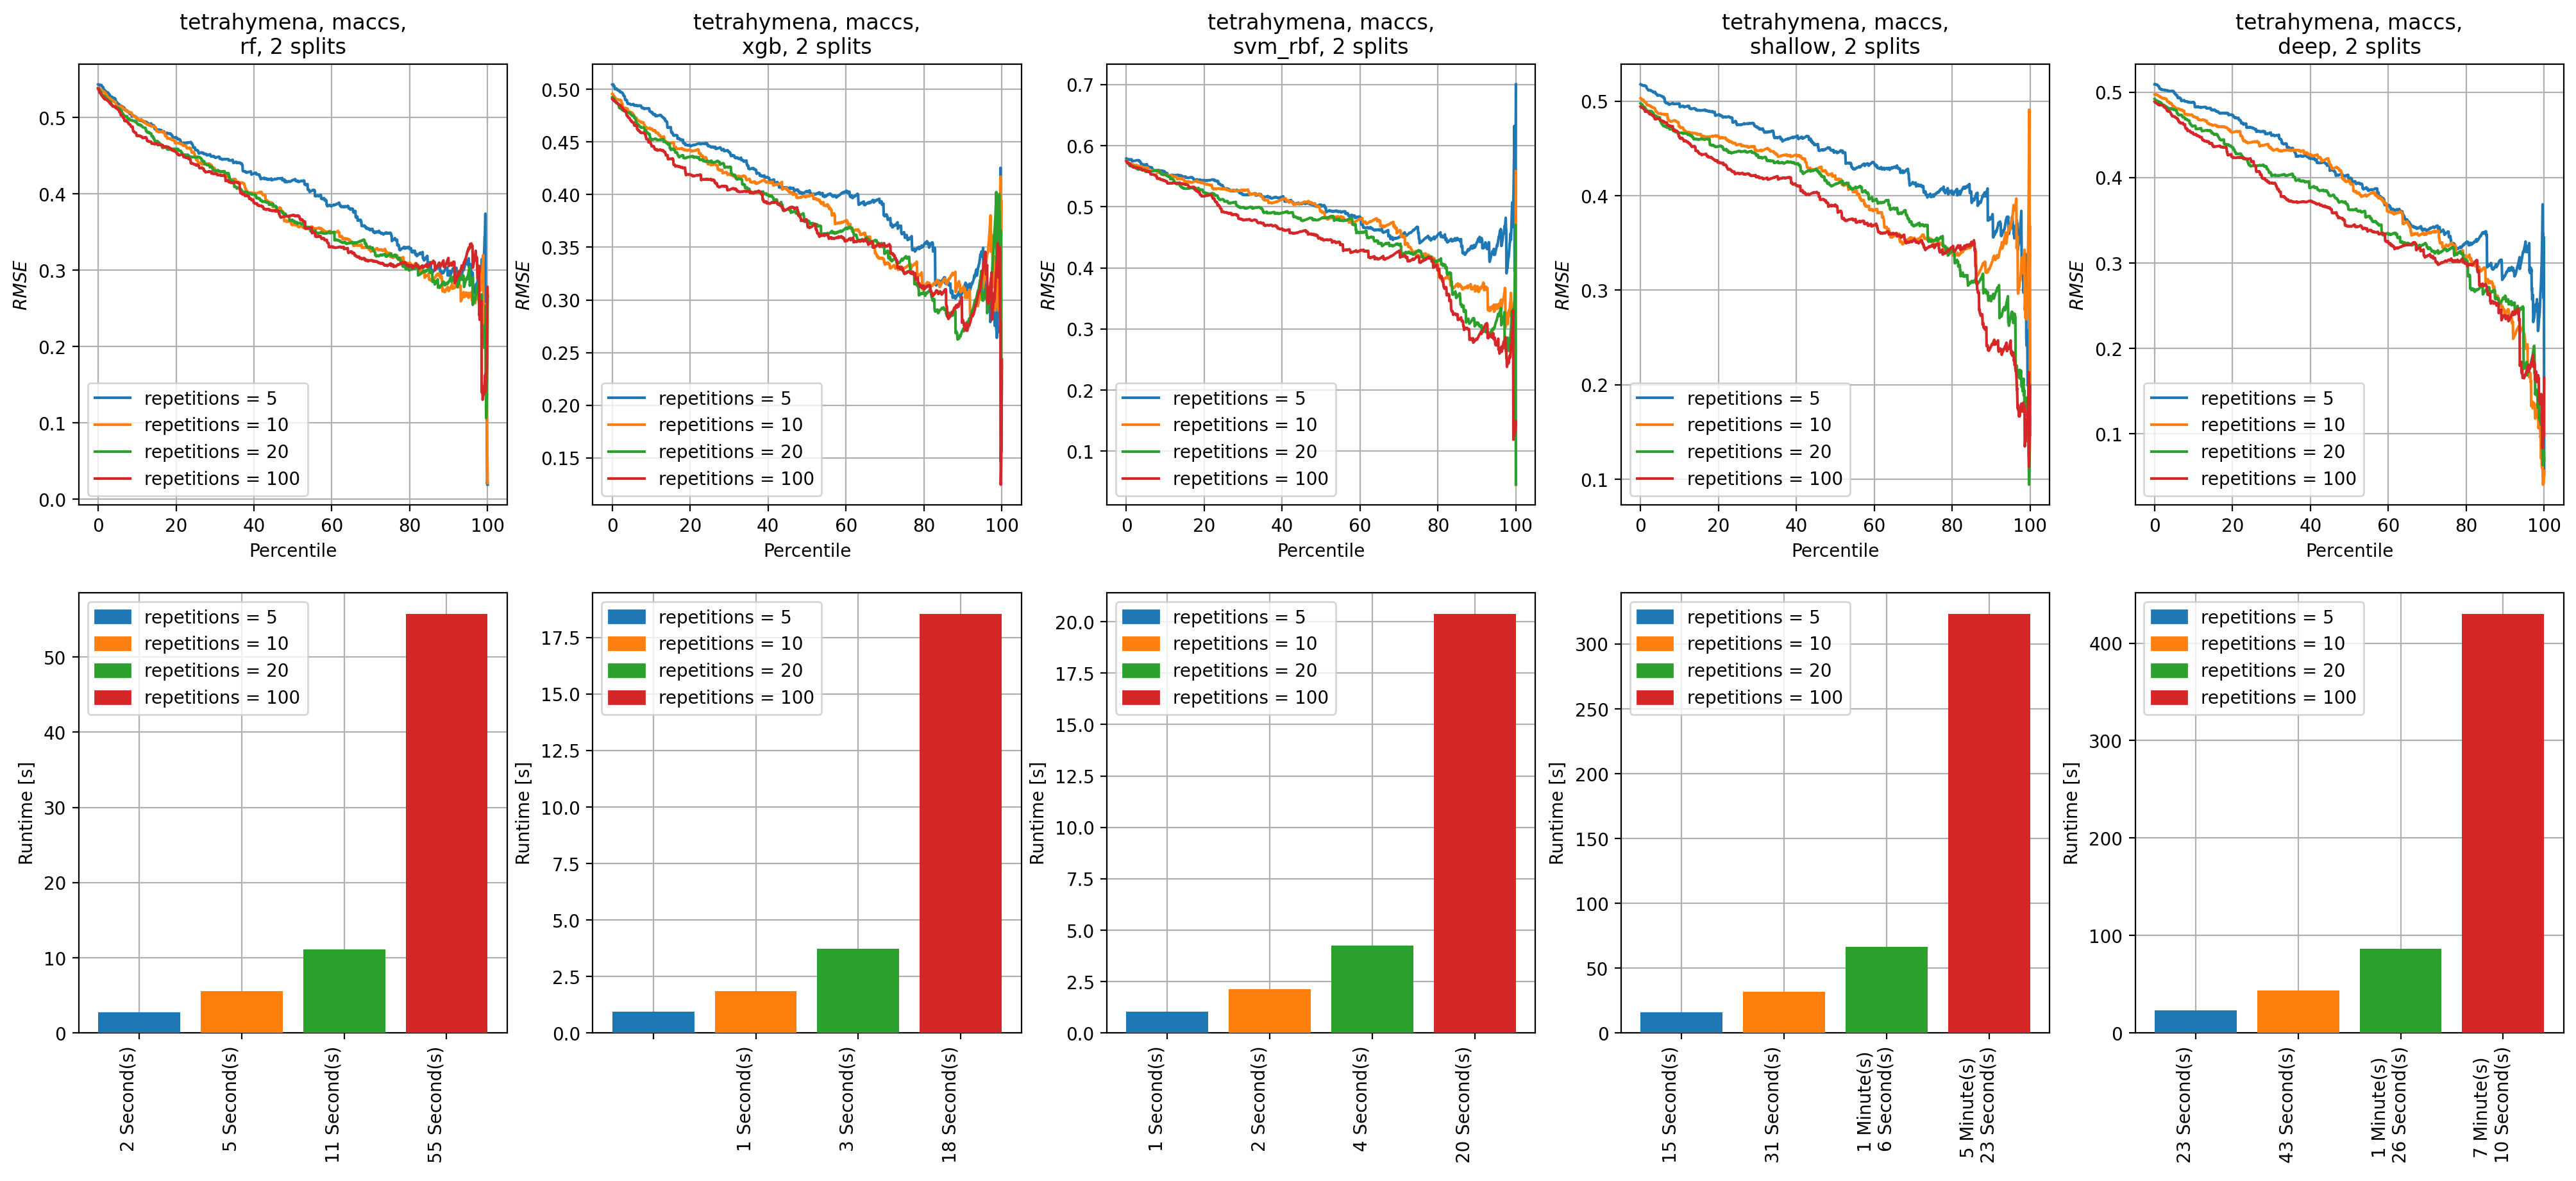

In [8]:
evaluation_automatization('tetrahymena', 'maccs', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], scale=False)

### Tetrahymena, ECFP, large-scale evaluation


At rf.


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At svm_rbf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [06:15<00:00,  3.76s/it]



At deep.


  0%|          | 0/5 [00:00<?, ?it/s]

Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [07:55<00:00,  4.75s/it]


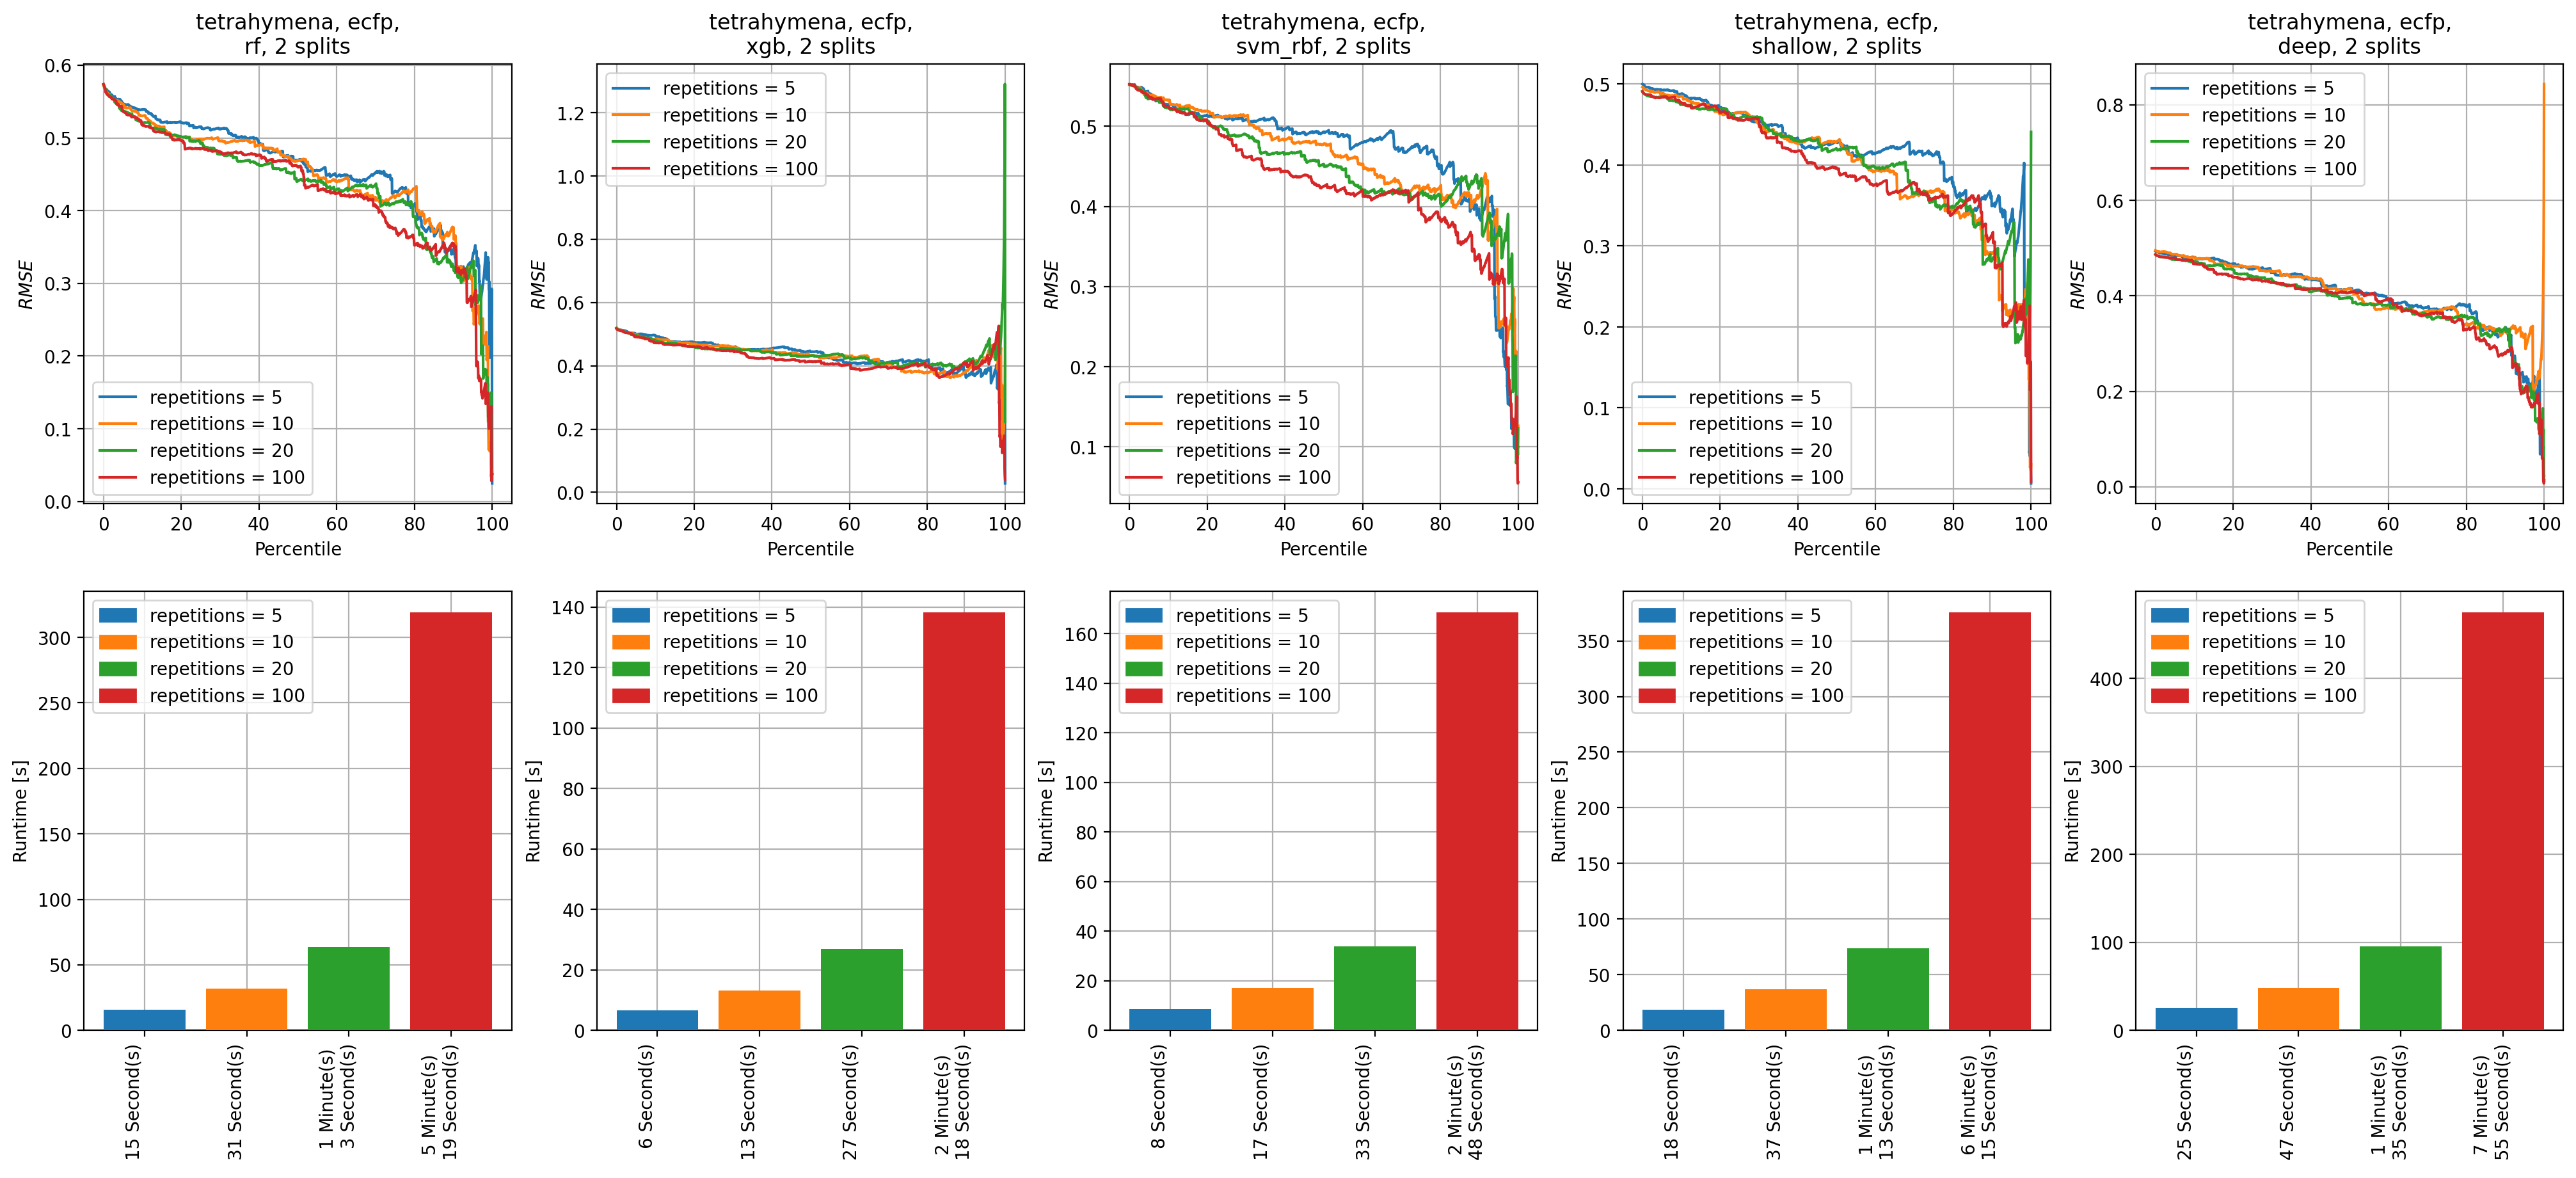

In [9]:
evaluation_automatization('tetrahymena', 'ecfp', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'], scale=False)

### FreeSolv, RDKit descriptors, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


 10%|█         | 1/10 [00:00<00:01,  5.09it/s]

Repetition [2/4]


  5%|▌         | 1/20 [00:00<00:03,  5.21it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


 40%|████      | 2/5 [00:00<00:00, 15.87it/s]


At svm_rbf.
Repetition [1/4]


 20%|██        | 2/10 [00:00<00:00, 16.04it/s]

Repetition [2/4]


 10%|█         | 2/20 [00:00<00:01, 15.77it/s]

Repetition [3/4]


  2%|▏         | 2/100 [00:00<00:06, 16.10it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [03:51<00:00,  2.32s/it]


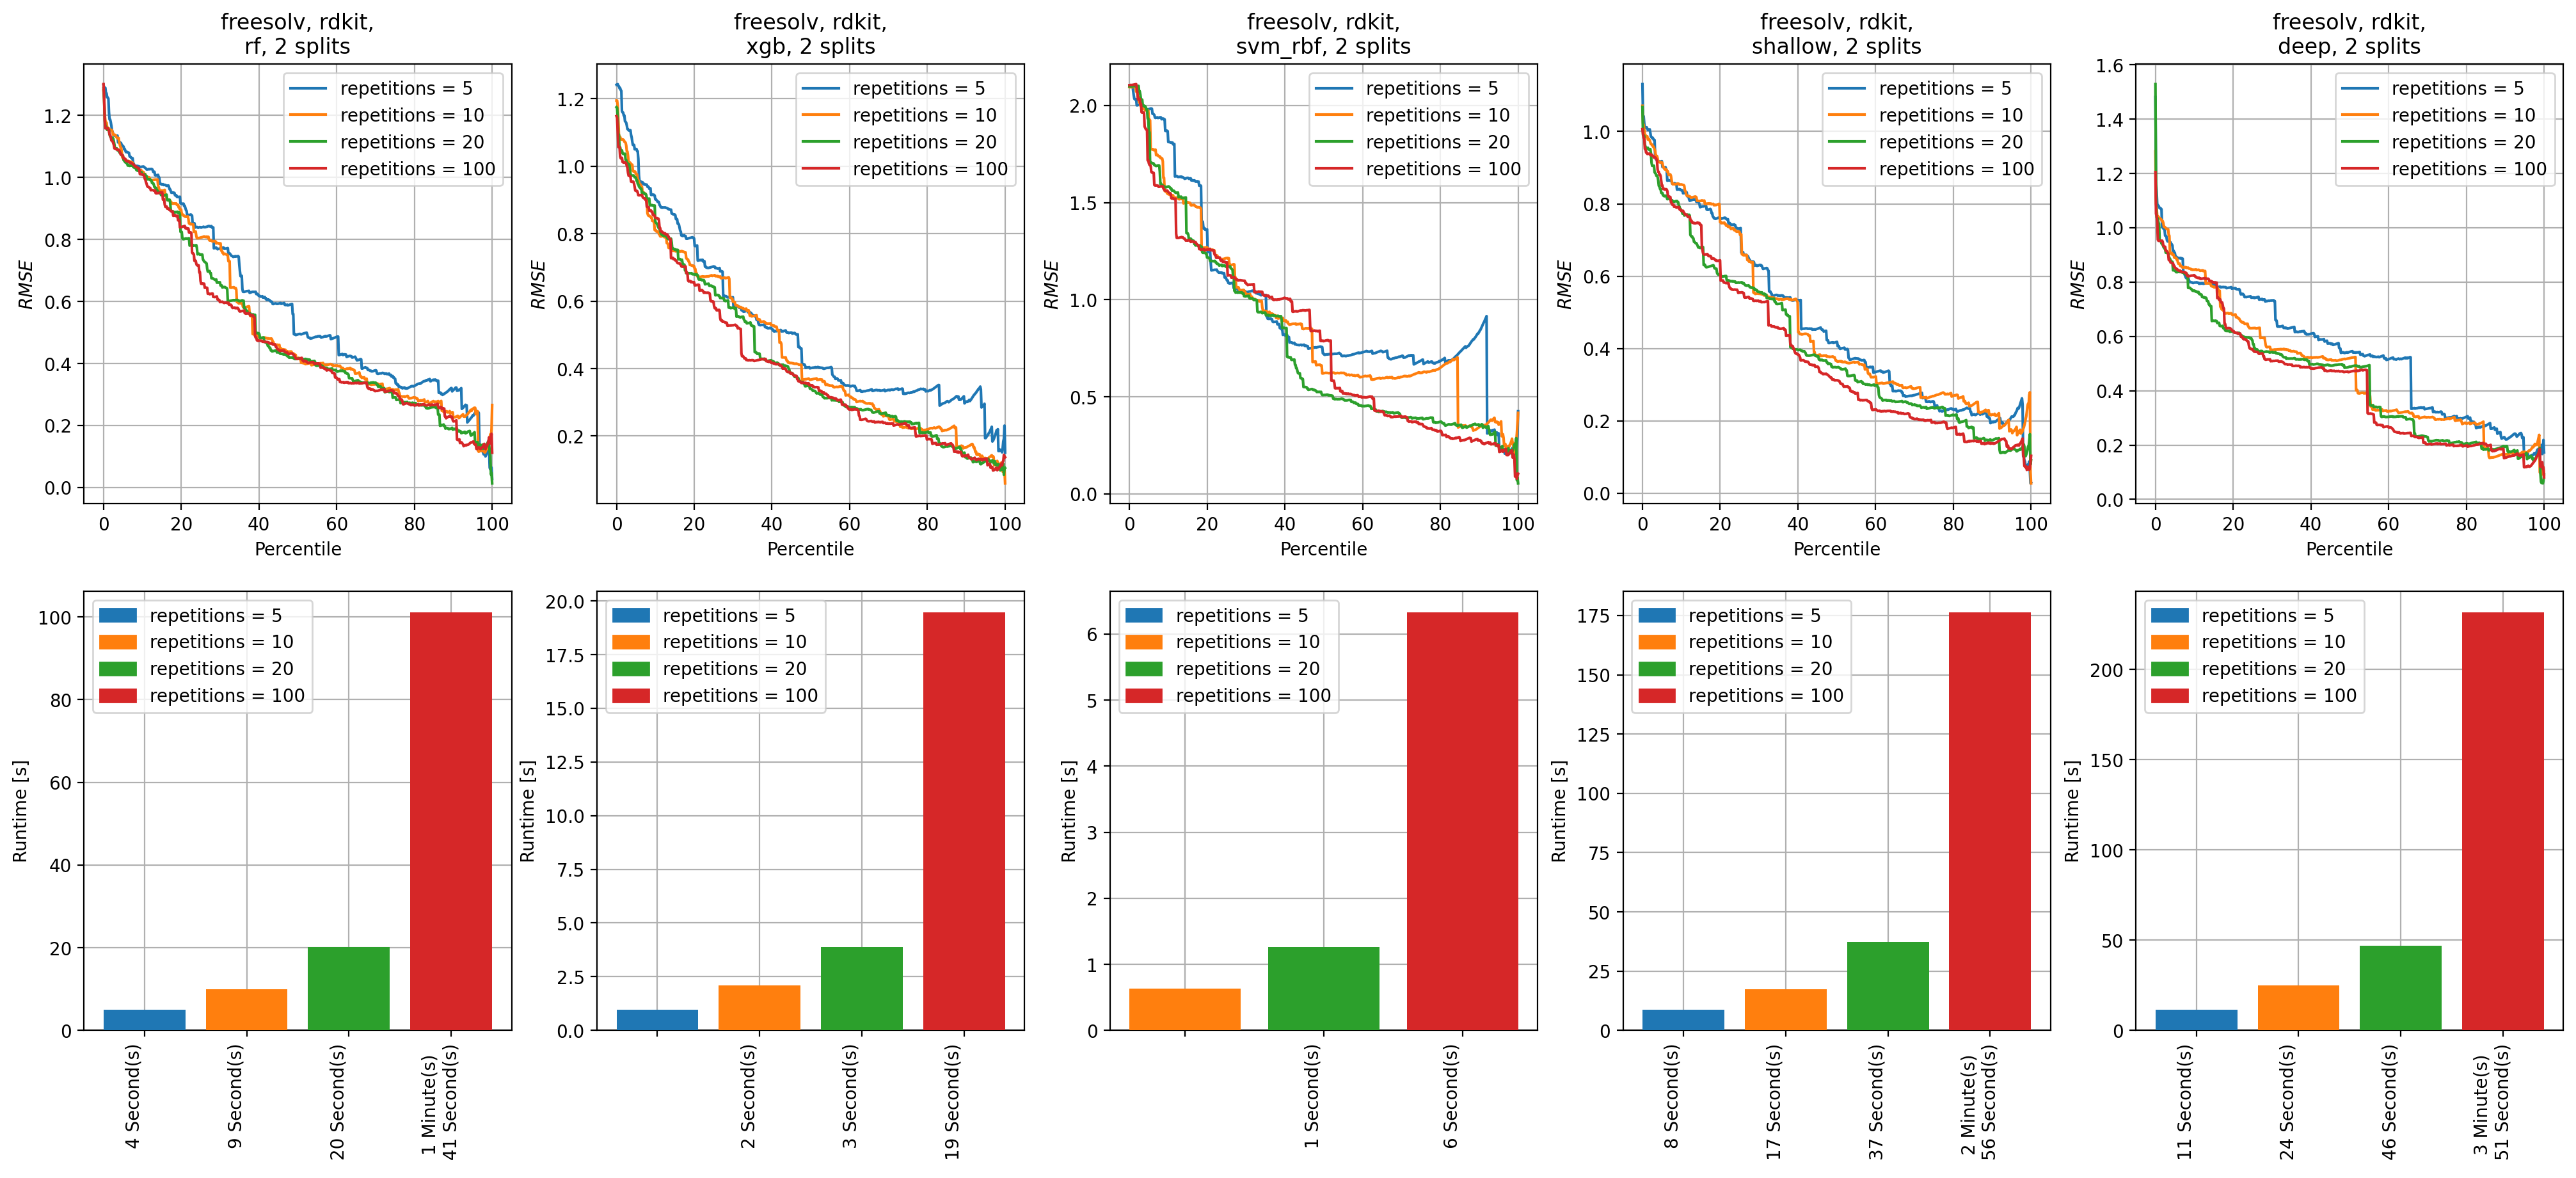

In [10]:
evaluation_automatization('freesolv', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])

### FreeSolv, CDDD, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


 20%|██        | 1/5 [00:00<00:00,  8.31it/s]


At svm_rbf.
Repetition [1/4]


 10%|█         | 1/10 [00:00<00:01,  8.56it/s]

Repetition [2/4]


  5%|▌         | 1/20 [00:00<00:02,  8.40it/s]

Repetition [3/4]


  1%|          | 1/100 [00:00<00:11,  8.66it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [03:58<00:00,  2.38s/it]


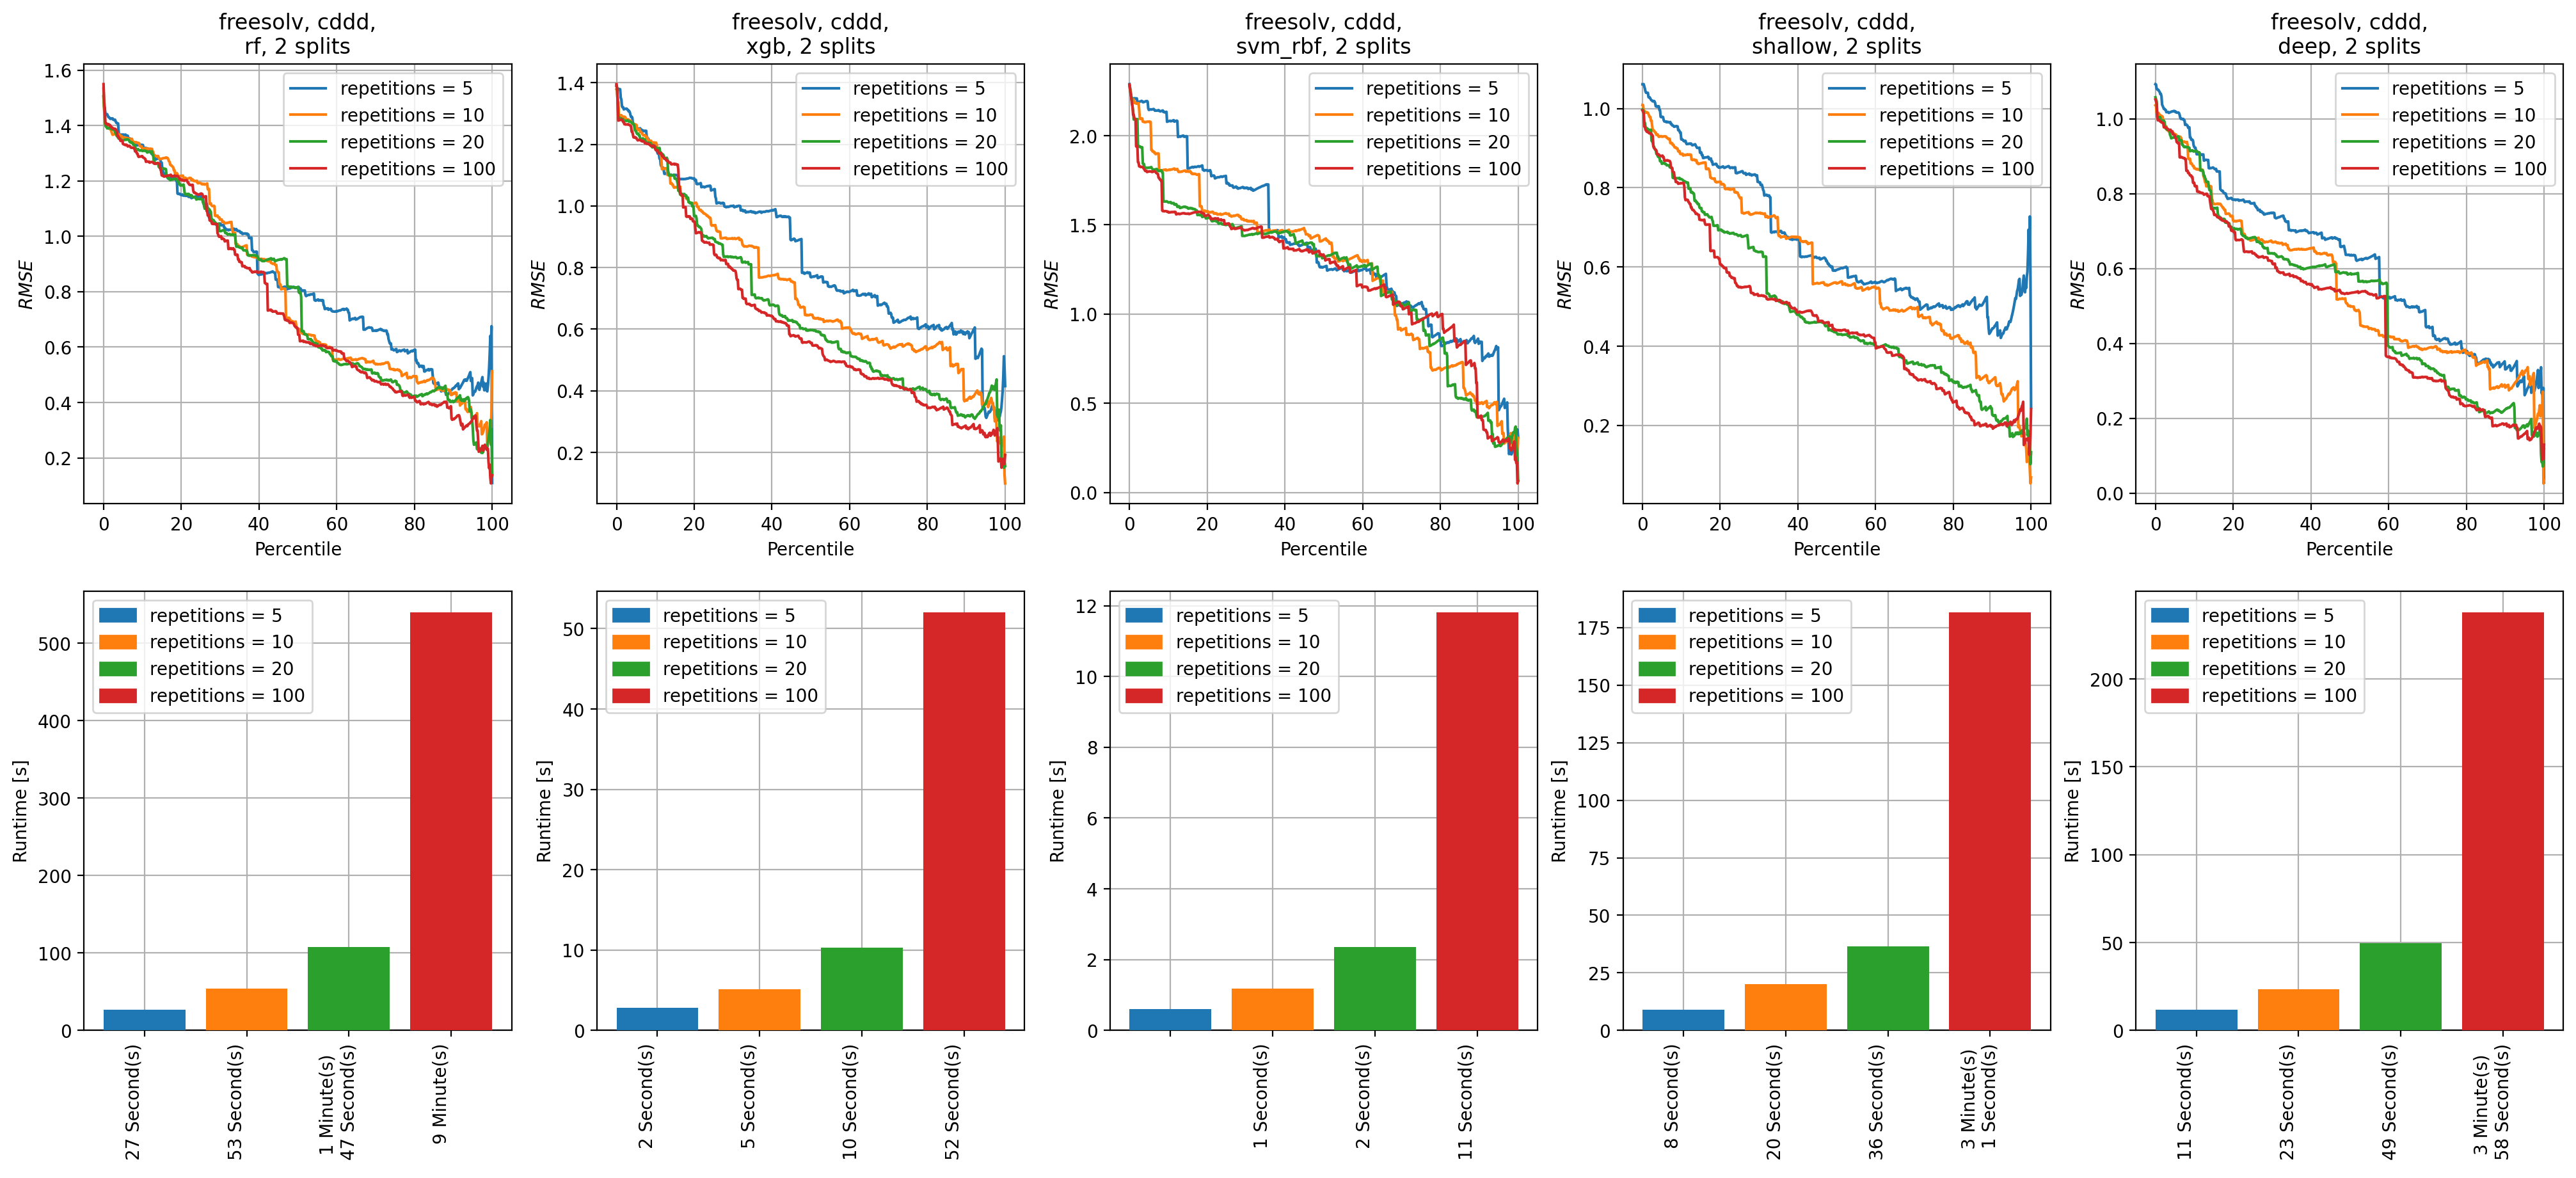

In [11]:
evaluation_automatization('freesolv', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])

### IL4, RDKit descriptors, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


 20%|██        | 1/5 [00:00<00:00,  5.53it/s]


At xgb.
Repetition [1/4]


 10%|█         | 1/10 [00:00<00:01,  5.46it/s]

Repetition [2/4]


  5%|▌         | 1/20 [00:00<00:03,  5.51it/s]

Repetition [3/4]


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

Repetition [4/4]


 40%|████      | 2/5 [00:00<00:00, 18.14it/s]


At svm_rbf.
Repetition [1/4]


 20%|██        | 2/10 [00:00<00:00, 16.84it/s]

Repetition [2/4]


 10%|█         | 2/20 [00:00<00:01, 17.65it/s]

Repetition [3/4]


  2%|▏         | 2/100 [00:00<00:05, 18.12it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


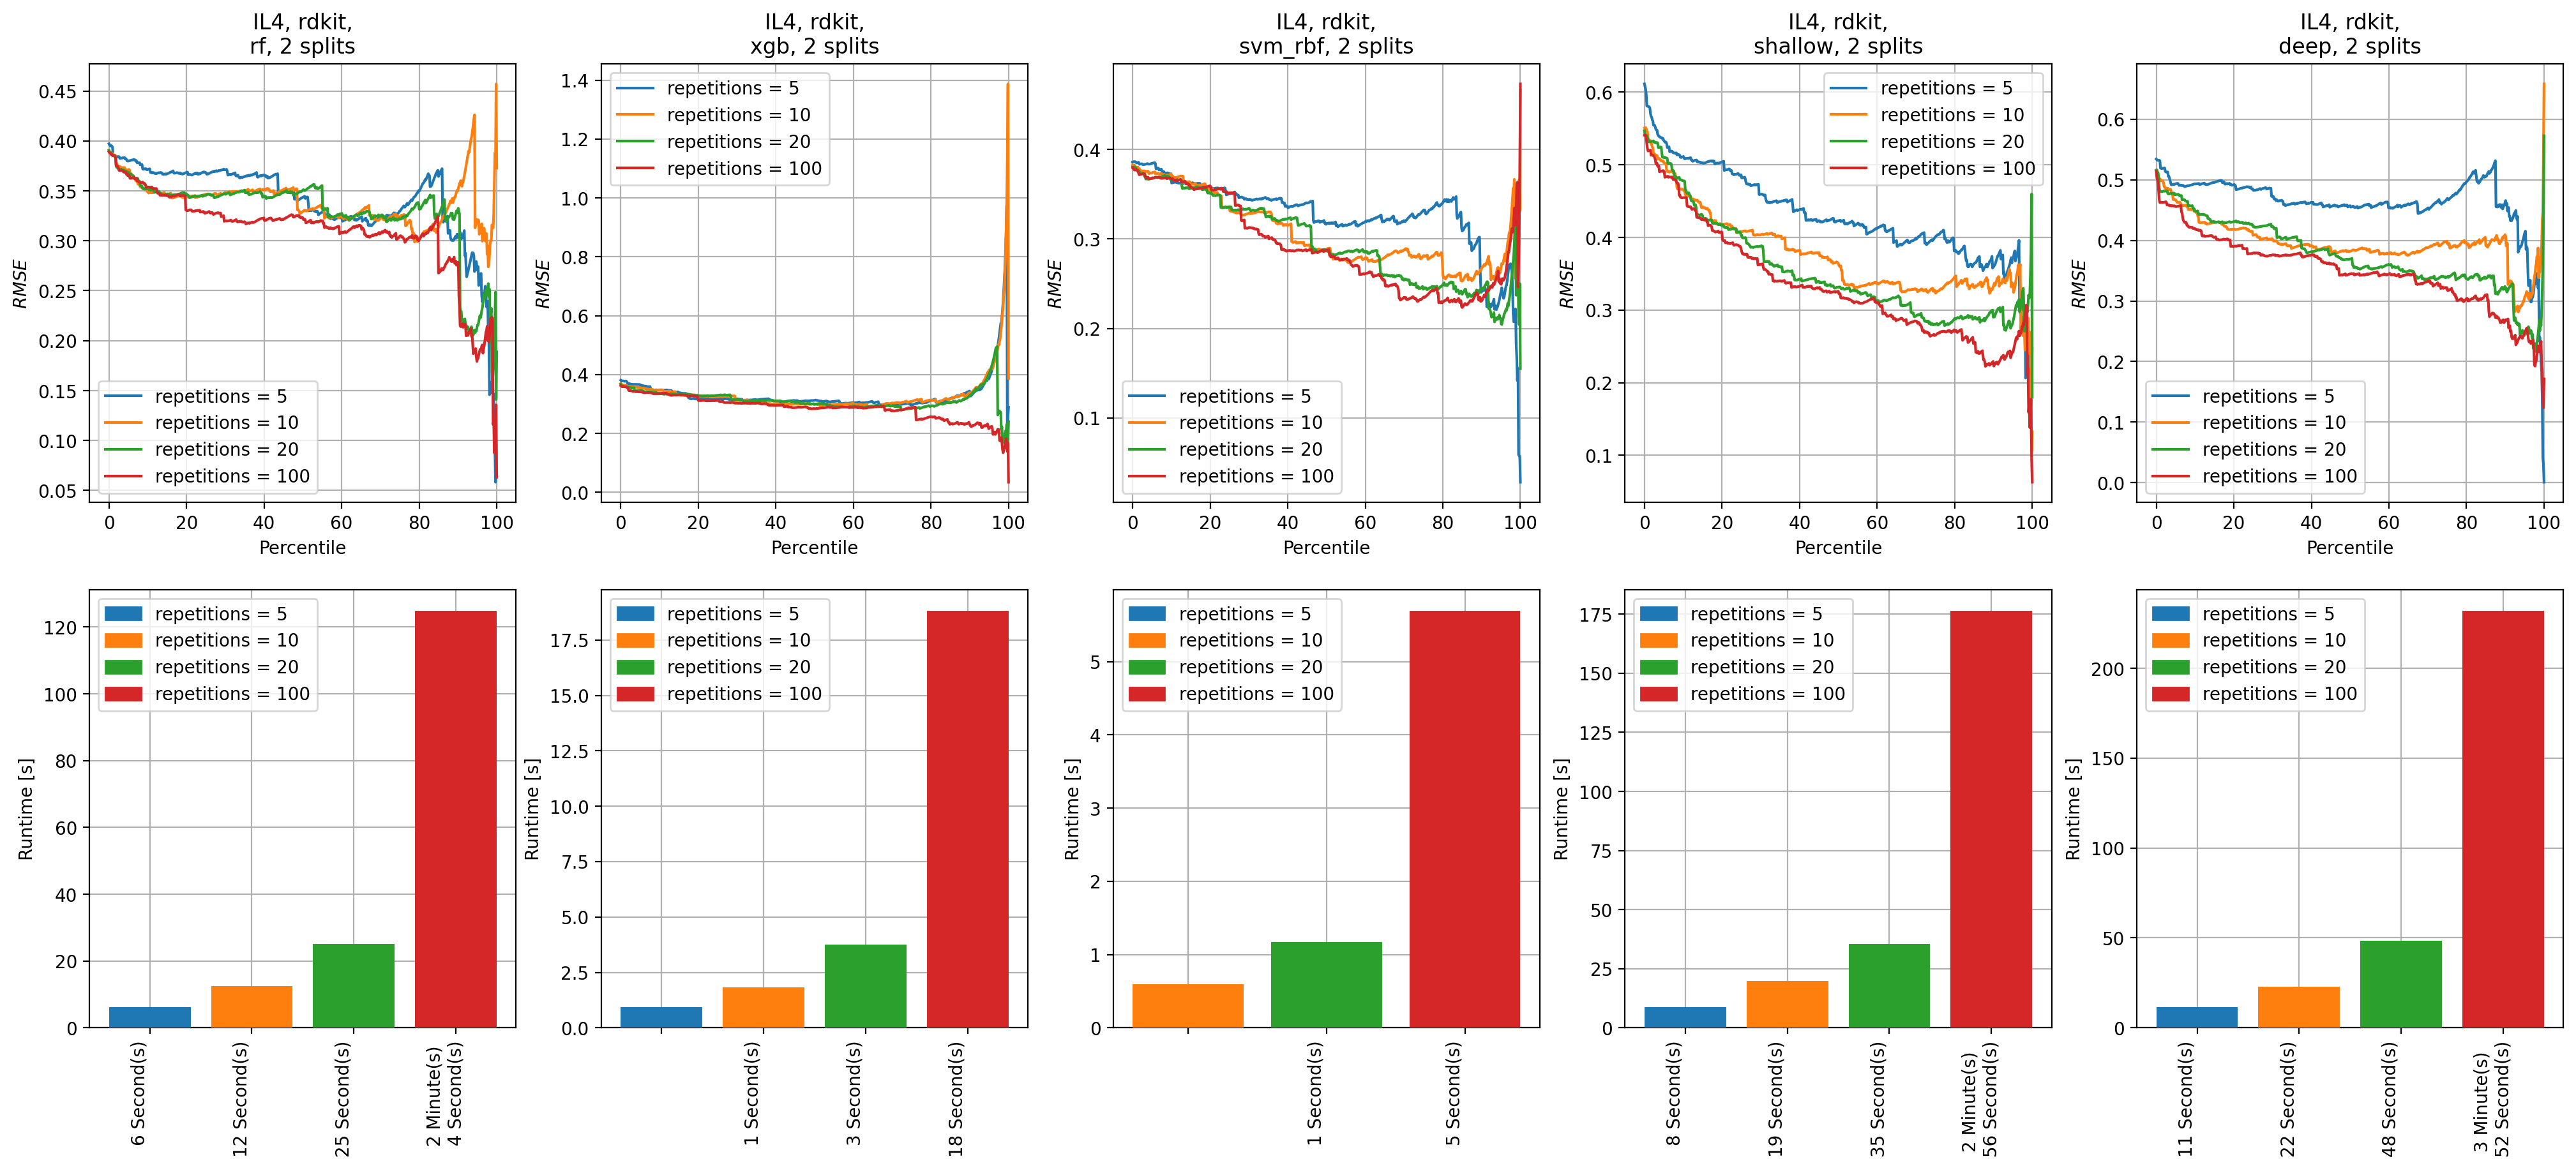

In [12]:
evaluation_automatization('IL4', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])

### IL4, CDDD, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


 20%|██        | 1/5 [00:00<00:00,  9.33it/s]


At svm_rbf.
Repetition [1/4]


 10%|█         | 1/10 [00:00<00:00,  9.50it/s]

Repetition [2/4]


  5%|▌         | 1/20 [00:00<00:01,  9.61it/s]

Repetition [3/4]


  1%|          | 1/100 [00:00<00:10,  9.49it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


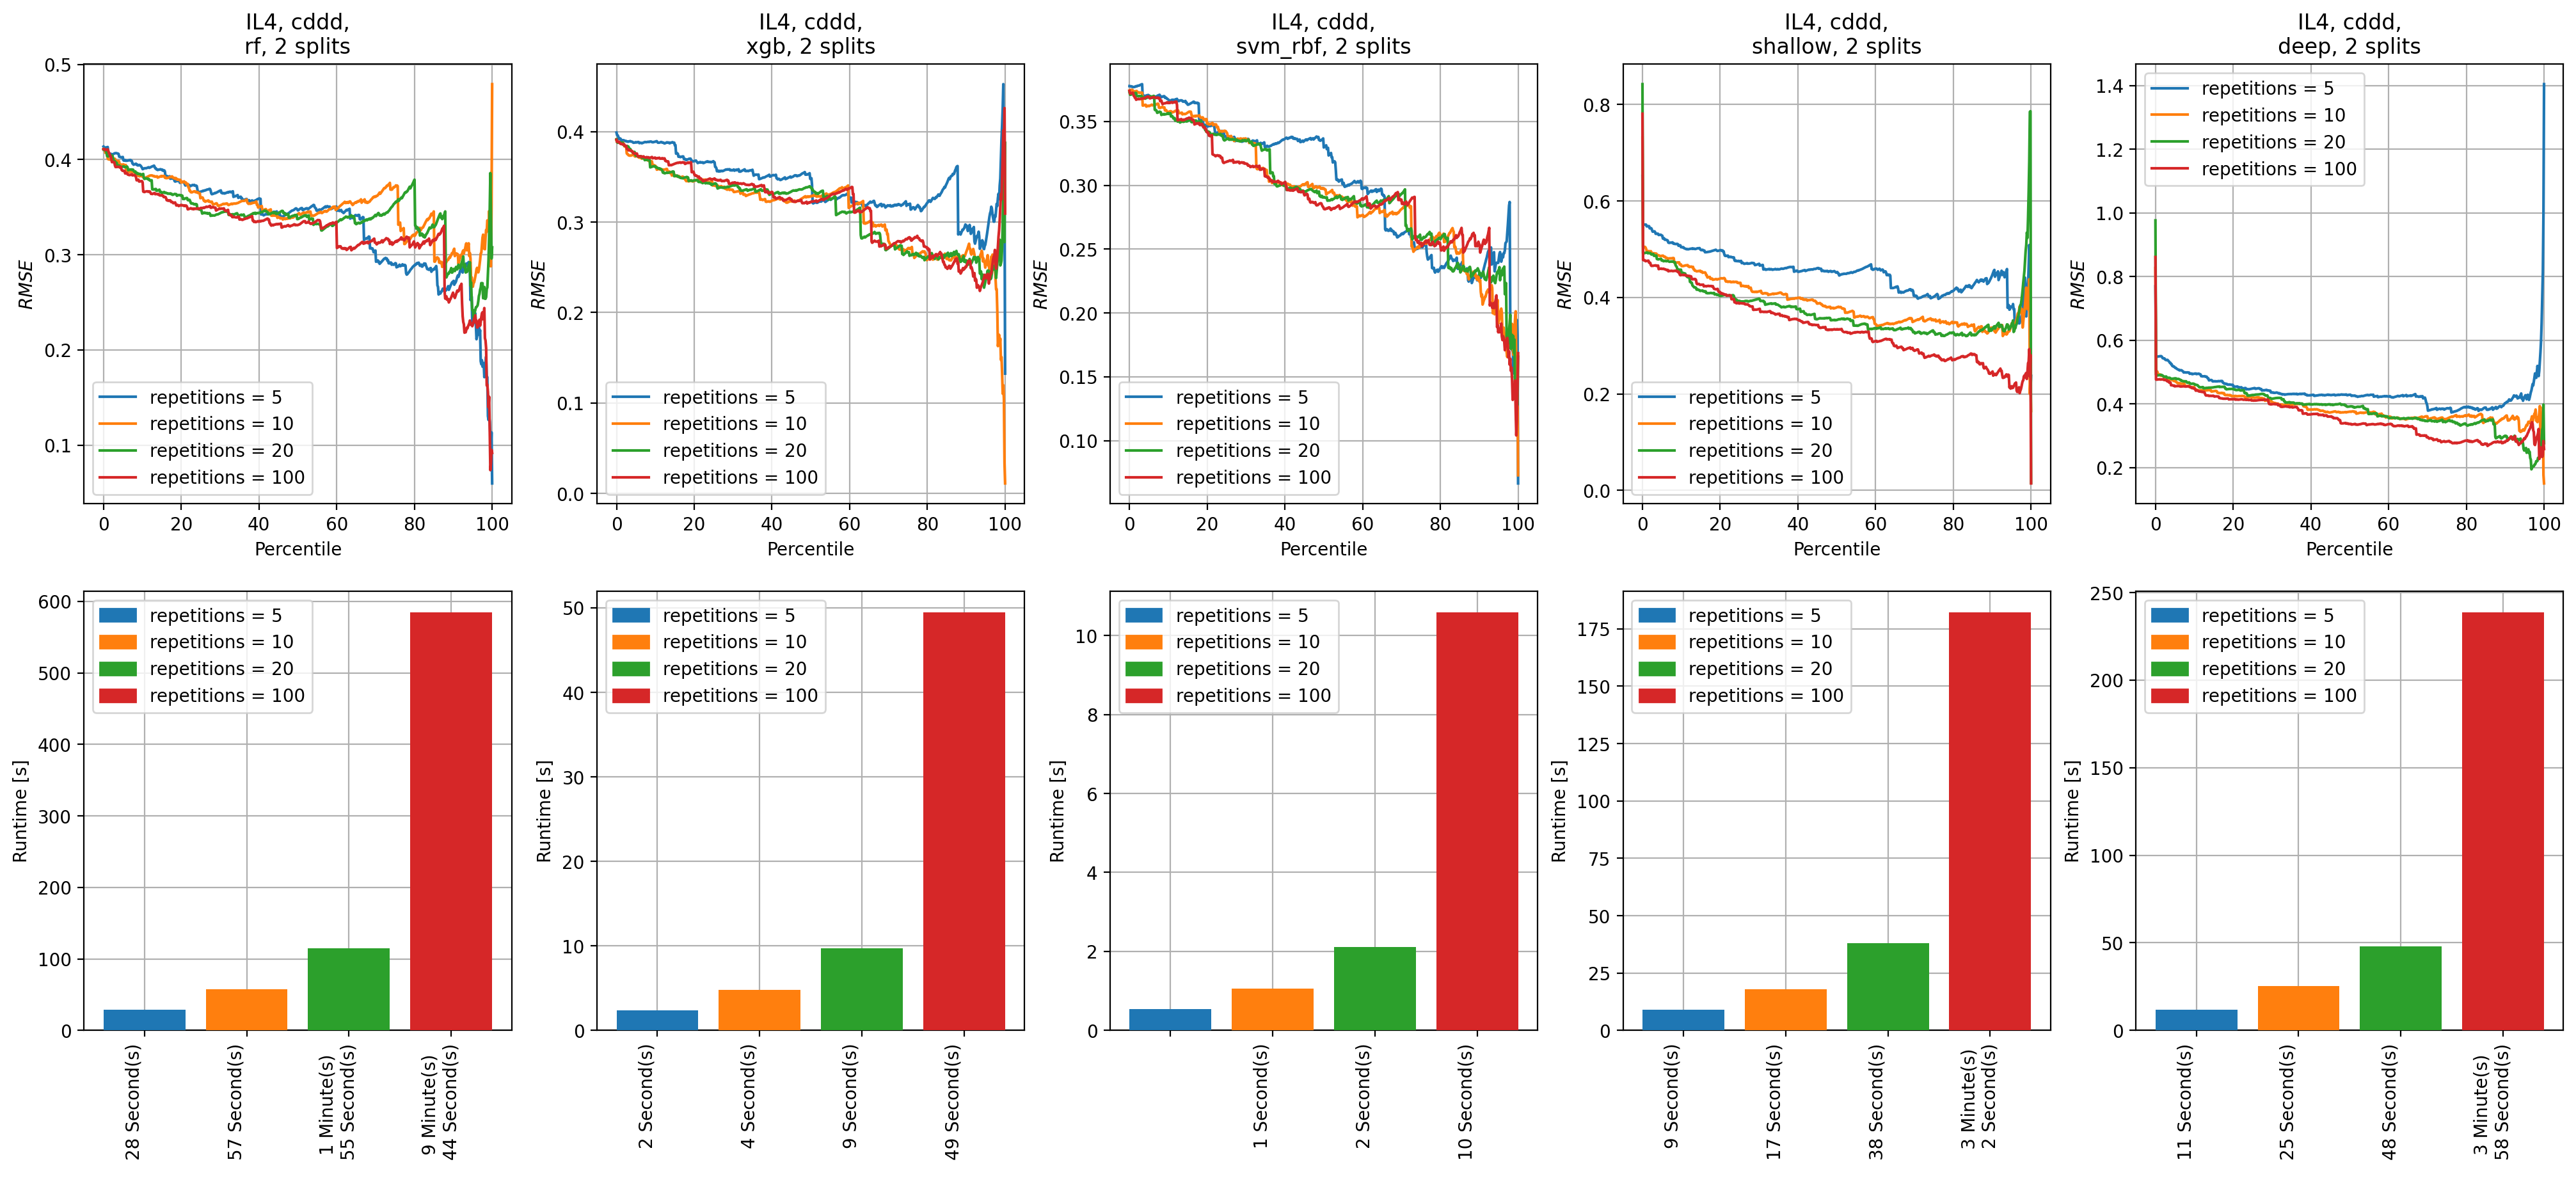

In [13]:
evaluation_automatization('IL4', 'cddd', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])

### P49146, RDKit descriptors, large-scale evaluation

  0%|          | 0/5 [00:00<?, ?it/s]


At rf.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At xgb.
Repetition [1/4]


 10%|█         | 1/10 [00:00<00:01,  5.90it/s]

Repetition [2/4]


  5%|▌         | 1/20 [00:00<00:03,  5.87it/s]

Repetition [3/4]


  1%|          | 1/100 [00:00<00:18,  5.45it/s]

Repetition [4/4]


 60%|██████    | 3/5 [00:00<00:00, 21.43it/s]


At svm_rbf.
Repetition [1/4]


 30%|███       | 3/10 [00:00<00:00, 21.26it/s]

Repetition [2/4]


 15%|█▌        | 3/20 [00:00<00:00, 21.93it/s]

Repetition [3/4]


  3%|▎         | 3/100 [00:00<00:04, 21.19it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At shallow.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


  0%|          | 0/5 [00:00<?, ?it/s]


At deep.
Repetition [1/4]


  0%|          | 0/10 [00:00<?, ?it/s]

Repetition [2/4]


  0%|          | 0/20 [00:00<?, ?it/s]

Repetition [3/4]


  0%|          | 0/100 [00:00<?, ?it/s]

Repetition [4/4]


100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


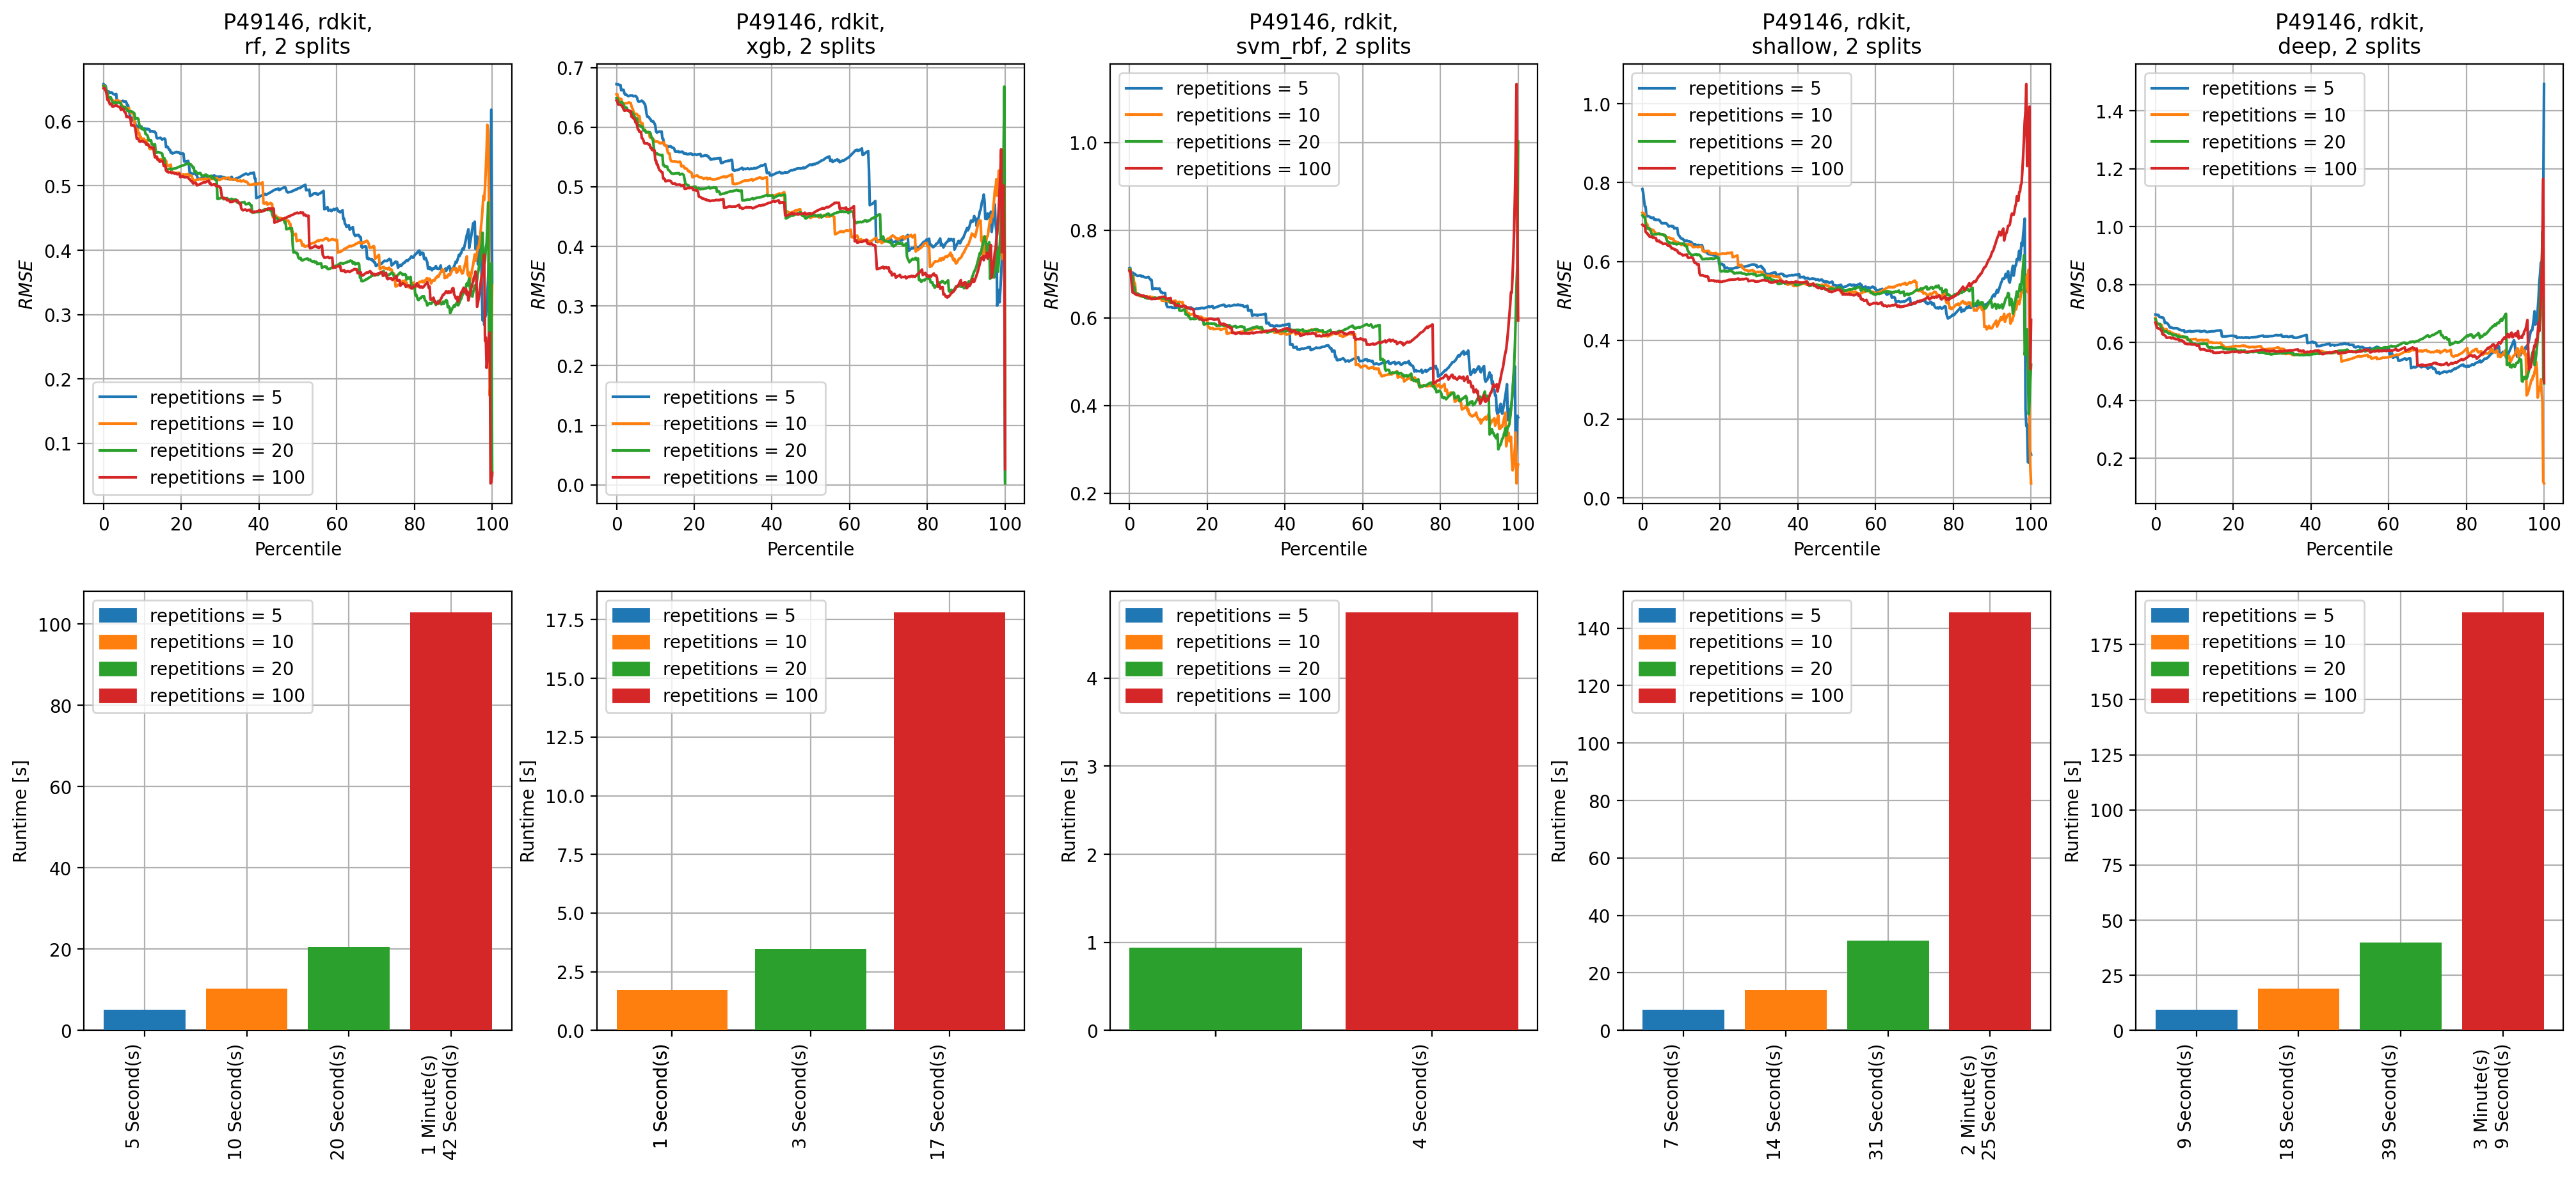

In [14]:
evaluation_automatization('P49146', 'rdkit', ['rf', 'xgb', 'svm_rbf', 'shallow', 'deep'])